# Classical `pyiron_atomistics` workflow

In [1]:
from pyiron_atomistics import Project

In [2]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

In [3]:
job = pr.create.job.Lammps("lmp")
job.structure = pr.create.structure.ase.bulk("Al", cubic=True)
job.potential = '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1'
murn = pr.create.job.Murnaghan("murn")
murn.ref_job = job
murn.run()

The job murn was saved and received the ID: 9
The job murn_0_9 was saved and received the ID: 10
The job murn_0_92 was saved and received the ID: 11
The job murn_0_94 was saved and received the ID: 12
The job murn_0_96 was saved and received the ID: 13
The job murn_0_98 was saved and received the ID: 14
The job murn_1_0 was saved and received the ID: 15
The job murn_1_02 was saved and received the ID: 16
The job murn_1_04 was saved and received the ID: 17
The job murn_1_06 was saved and received the ID: 18
The job murn_1_08 was saved and received the ID: 19
The job murn_1_1 was saved and received the ID: 20


In [4]:
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'murnaghan', 'pouriertarantola', 'vinet']"
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume defined by ref_ham
4,axes,"(x, y, z)",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If given vol_range and num_points take no effect.
6,allow_aborted,0,"The number of child jobs that are allowed to abort, before the whole job is considered aborted."


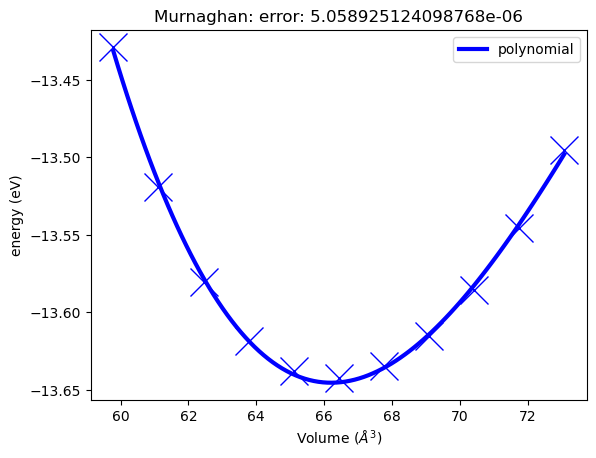

<Axes: title={'center': 'Murnaghan: error: 5.058925124098768e-06'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [5]:
murn.plot()

# Functional `pyiron_atomistics`

In [6]:
import os
import shutil
from ase.build import bulk
from atomistics.calculators.wrapper import as_task_dict_evaluator
from atomistics.workflows.evcurve.helper import (
    analyse_structures_helper,
    generate_structures_helper,
)
import matplotlib.pyplot as plt
from pyiron_atomistics.lammps.lammps import lammps_function

In [7]:
@as_task_dict_evaluator
def evaluate_with_lammps(
    structure,
    tasks,
    potential_dataframe,
) :
    results = {}
    path_lmp_calculation = os.path.abspath("lmp_working_directory")
    if os.path.exists(path_lmp_calculation):
        shutil.rmtree(path_lmp_calculation)
    if "calc_energy" in tasks:
        shell_output, parsed_output, job_crashed = lammps_function(
            working_directory=path_lmp_calculation,
            structure=structure,
            potential=potential_dataframe,
        )
        return {"energy": parsed_output["generic"]["energy_tot"][-1]}
    else:
        raise ValueError("The LAMMPS calculator does not implement:", tasks)
    return results

In [8]:
structure_dict = generate_structures_helper(
    structure=bulk("Al", cubic=True),
    vol_range=0.1,
    num_points=11,
    strain_lst=None,
    axes=("x", "y", "z"),
)

In [9]:
result_dict = evaluate_with_lammps(
    task_dict={"calc_energy": structure_dict},
    potential_dataframe='2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
)

In [10]:
fit_dict = analyse_structures_helper(
    output_dict=result_dict,
    structure_dict=structure_dict,
    fit_type="polynomial",
    fit_order=3,
)

Text(0, 0.5, 'Energy (eV)')

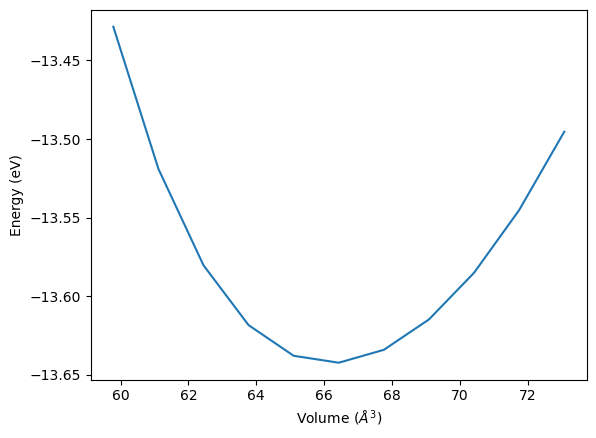

In [11]:
plt.plot(fit_dict["volume"], fit_dict["energy"])
plt.xlabel("Volume ($\AA^3$)")
plt.ylabel("Energy (eV)")